In [1]:
from IPython.core.display import Markdown, display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

import traceback
import numpy as np
import scipy.stats as ss
import yaml
import itertools
import sys
import os
import subprocess
from os import path
import pickle
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from sklearn.linear_model import LinearRegression, TheilSenRegressor, RANSACRegressor, HuberRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline

def printmd(*args):
    display(Markdown(' '.join(map(str, args))))

/tmp/ipykernel_49887/4167336305.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import Markdown, display, HTML


In [2]:
# !ros2 run local_planning_performance_modelling compute_metrics -r "~/ds/performance_modelling/output/test_local_planning/*" -s

In [3]:
# !ros2 run local_planning_performance_modelling compute_metrics -r "~/ds/performance_modelling/output/test_local_planning_gen_circles/*" -s

In [4]:
local_planner_color = {'dwb': 'blue', 'rpp': 'orange', 'teb': 'green', 'rpp_bad': 'yellow'}
local_planner_symbol = {'dwb': 'o', 'rpp': '^', 'teb': 'x', 'rpp_bad': 's'}
robot_model_color = {'hunter': 'cyan', 'turtle': 'green'}
pd.options.display.width = 500
pd.options.display.max_rows = 0
pd.options.display.float_format = '{:,.3f}'.format
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['lines.linewidth'] = 2
# plt.rcParams['lines.markersize'] = 3
# plt.rcParams['lines.marker'] = 'o'

# fg_color = 'white'
# plt.rcParams['grid.color'] = 'gray'
# plt.rcParams['text.color'] = fg_color
# plt.rcParams['ytick.color'] = fg_color
# plt.rcParams['xtick.color'] = fg_color
# plt.rcParams['axes.labelcolor'] = fg_color
# plt.rcParams['axes.edgecolor'] = fg_color

# bg_color = "#323a48"
# plt.rcParams['figure.facecolor'] = bg_color
# plt.rcParams['axes.facecolor'] = bg_color
# plt.rcParams['legend.facecolor'] = bg_color

In [5]:
# df = pd.read_csv(path.expanduser("~/ds/performance_modelling/output/test_local_planning_all/results.csv"))
# with open(path.expanduser("~/ds/performance_modelling/output/test_local_planning_all/results_info.yaml")) as results_info_file:
#     results_info = yaml.safe_load(results_info_file)

df = pd.read_csv(path.expanduser("~/ds/performance_modelling/output/test_local_planning/results.csv"))
with open(path.expanduser("~/ds/performance_modelling/output/test_local_planning/results_info.yaml")) as results_info_file:
    results_info = yaml.safe_load(results_info_file)
    
df.rename(inplace=True, columns={
    'collisionless_localization_update_absolute_translation_error_mean': 'absolute_translation_error',
    'collisionless_localization_update_absolute_rotation_error_mean': 'absolute_rotation_error',
    'collisionless_localization_update_normalized_relative_translation_error_mean': 'normalized_relative_translation_error',
    'collisionless_localization_update_normalized_relative_rotation_error_mean': 'normalized_relative_rotation_error',
    'localization_update_rate_mean': 'localization_update_rate',
})


# TEMP: only consider real localization
df = df[df.localization_node != 'localization_generator']
# df = df[df.amcl_alpha_factor == 1.0]

# df = df[df.amcl_alpha_factor.notna()]

# turn odometry_error into beta_1..4
results_info['run_parameter_names'] += ['beta_1', 'beta_2', 'beta_3', 'beta_4']
results_info['run_parameter_names'].remove('odometry_error')
for i in range(0, 4):
    df[f'beta_{i+1}'] = df['odometry_error'].apply(lambda x: eval(x)[i])
del df['odometry_error']

df.loc[df.robot_model == 'turtlebot3_waffle_performance_modelling', 'robot_model'] = 'turtle'
df.loc[df.robot_model == 'hunter2', 'robot_model'] = 'hunter'

run_parameters = [c for c in list(df.columns) if c in results_info['run_parameter_names']]
run_parameters += ['max_steering_angle_deg']
metrics_versions = [c for c in list(df.columns) if '_version' in c]
everything_else = ['run_id', 'session_id', 'run_number', 'goal_index']
metrics = [c for c in df.columns if c not in metrics_versions + run_parameters + everything_else]
metrics_and_versions = [c for c in list(df.columns) if '_version' in c or c in metrics]

cpu_time_metrics = [c for c in metrics if 'cpu_time' in c]
max_memory_metrics = [c for c in metrics if 'max_memory' in c]

# add useful parameters
df['session_id'] =  df['run_id'].apply(lambda x:  x.split('_')[1]+'_'+x.split('_')[2]+'_'+x.split('_')[3])
df['run_number'] =  df['run_id'].apply(lambda x:  int(x.split('_')[5]))
df[max_memory_metrics] = df[max_memory_metrics]/1024**2
#df.max_steering_angle_deg = df.max_steering_angle_deg.fillna(90)
df['max_steering_angle_deg'] = 90    # crea una nuova colonna e riempie le righe con il valore 90
df["run_index_str"] = df['run_index'].apply(lambda x: str(x))
df['goal_index'] = df.environment_name + '_' + df.run_index_str

# add metrics from existing ones
df['average_velocity'] = df['trajectory_length'] / df['execution_time']
df['success_rate'] = df['success_rate'] & (1 - df['collision_rate'])

metrics += ['average_velocity']
metrics_and_versions += ['average_velocity']

# add aggregated data
min_trajectory_length_group_df = df.groupby(["environment_name", "run_index", "success_rate"])
for (environment_name, run_index, success_rate), group_df in min_trajectory_length_group_df:
    df.loc[(df.environment_name == environment_name) & (df.run_index == run_index) & (success_rate), 'min_trajectory_length'] = group_df.trajectory_length.min()
    df.loc[(df.environment_name == environment_name) & (df.run_index == run_index) & (success_rate), 'std_trajectory_length'] = group_df.trajectory_length.std()
    df.loc[(df.environment_name == environment_name) & (df.run_index == run_index) & (success_rate), 'var_trajectory_length'] = group_df.trajectory_length.var()
    df.loc[(df.environment_name == environment_name) & (df.run_index == run_index) & (success_rate), 'mean_trajectory_length'] = group_df.trajectory_length.mean()
    df.loc[(df.environment_name == environment_name) & (df.run_index == run_index) & (success_rate), 'median_trajectory_length'] = group_df.trajectory_length.median()
df['norm_trajectory_length'] = df.trajectory_length / df.min_trajectory_length
df['norm_trajectory_length_std'] = df.trajectory_length / df.min_trajectory_length / df.std_trajectory_length
df['norm_trajectory_length_mean'] = df.trajectory_length / df.mean_trajectory_length
df['norm_trajectory_length_median'] = df.trajectory_length / df.median_trajectory_length
metrics += ['norm_trajectory_length']
metrics += ['min_trajectory_length']
metrics += ['mean_trajectory_length']
metrics += ['median_trajectory_length']
metrics += ['norm_trajectory_length_std']
metrics += ['norm_trajectory_length_mean']
metrics += ['norm_trajectory_length_median']
metrics_and_versions += ['norm_trajectory_length']
metrics_and_versions += ['mean_trajectory_length']
metrics_and_versions += ['median_trajectory_length']
metrics_and_versions += ['norm_trajectory_length_std']
metrics_and_versions += ['norm_trajectory_length_mean']
metrics_and_versions += ['norm_trajectory_length_median']

min_execution_time_group_df = df.groupby(["environment_name", "run_index", "success_rate"])
for (environment_name, run_index, success_rate), group_df in min_execution_time_group_df:
    df.loc[(df.environment_name == environment_name) & (df.run_index == run_index) & (success_rate), 'min_execution_time'] = group_df.execution_time.min()
df['norm_execution_time'] = df.execution_time / df.min_execution_time
metrics += ['norm_execution_time']
metrics_and_versions += ['norm_execution_time']

printmd("## Number of Runs")
printmd(f"    {len(df.run_id.unique())}")

printmd("## Run Parameters")
for name in [run_parameter_name for run_parameter_name in run_parameters if 'localization_generator_' not in run_parameter_name]:
    values = list(df[name].unique())
    printmd(f"    {name:<70}", sorted(values))

printmd("## Metrics")
for name in metrics_and_versions:
    if name in metrics_versions:
        if len(df[name].unique()) == 1:
            printmd(f"    {name:<70} {sorted(df[name].unique())}")
        else:
            printmd(f"<code><font style='background-color:yellow;font-family:monospace'>{name:<70}{sorted(df[name].unique())} </font></code> ⚠️")
    else:
        printmd(f"    {name:<70} min: {df[name].min(skipna=True):10.4g} {'avg':>15}: {df[name].mean(skipna=True):10.4g} {'max':>15}: {df[name].max(skipna=True):10.4g} {'nan':>15}: {sum(df[name].isna()):10.4g}")

/home/emanuele/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


## Number of Runs

    361

## Run Parameters

    amcl_alpha_factor                                                      [0.0, 1.0]

    environment_name                                                       ['airlab', 'intel']

    global_planner_node                                                    ['global_planner']

    local_planner_node                                                     ['arena', 'dwa']

    localization_node                                                      ['amcl']

    robot_model                                                            ['turtle']

    run_index                                                              [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

    run_replication_index                                                  [nan, 0.0, 1.0]

    beta_1                                                                 [0.0, 0.02, 0.05, 0.1]

    beta_2                                                                 [0.0]

    beta_3                                                                 [0.0, 0.02, 0.05, 0.1]

    beta_4                                                                 [0.0]

    max_steering_angle_deg                                                 [90]

## Metrics

    collision_rate                                                         min:          0             avg:     0.1163             max:          1             nan:          0

    collision_time                                                         min:       5.78             avg:      23.51             max:      111.7             nan:        319

    collision_rate_version                                                 [3]

    clearance                                                              min:        nan             avg:        nan             max:        nan             nan:        361

    clearance_version                                                      [2]

    minimum_clearance                                                      min:          0             avg:      1.087             max:      1.862             nan:          0

    average_clearance                                                      min:     0.1439             avg:      1.429             max:      2.254             nan:          0

    median_clearance                                                       min:          0             avg:      1.385             max:       2.26             nan:          0

    maximum_clearance                                                      min:     0.7892             avg:      1.945             max:      2.685             nan:          0

    trajectory_length                                                      min:   0.001996             avg:      5.758             max:      24.79             nan:        244

    trajectory_length_version                                              [1]

    execution_time                                                         min:      1.047             avg:      56.28             max:      136.9             nan:        244

    execution_time_version                                                 [1]

    success_rate                                                           min:          0             avg:     0.1884             max:          1             nan:          0

    success_rate_version                                                   [1]

    odometry_error_alpha_1_mean                                            min:  0.0001589             avg:    0.04817             max:     0.8999             nan:        245

    odometry_error_alpha_1_std                                             min:  0.0004746             avg:     0.2341             max:      3.498             nan:        245

    odometry_error_alpha_2_mean                                            min:  0.0003747             avg:    0.06326             max:      1.699             nan:        245

    odometry_error_alpha_2_std                                             min:   0.001366             avg:      0.304             max:      8.319             nan:        245

    odometry_error_alpha_3_mean                                            min:  0.0003439             avg:   0.004613             max:    0.08637             nan:        245

    odometry_error_alpha_3_std                                             min:  0.0003899             avg:    0.01712             max:     0.4154             nan:        245

    odometry_error_alpha_4_mean                                            min:  0.0001913             avg:   0.002788             max:    0.05563             nan:        245

    odometry_error_alpha_4_std                                             min:  0.0003278             avg:    0.01205             max:     0.3269             nan:        245

    odometry_error_version                                                 [2]

    localization_update_absolute_translation_error_mean                    min:    0.09327             avg:     0.1826             max:      1.818             nan:        245

    localization_update_absolute_translation_error_std                     min:   0.008292             avg:    0.05903             max:     0.4286             nan:        245

    localization_update_absolute_rotation_error_mean                       min:   0.003973             avg:    0.03009             max:     0.9176             nan:        245

    localization_update_absolute_rotation_error_std                        min:   0.003103             avg:    0.04895             max:     0.7649             nan:        245

    localization_update_relative_translation_error_mean                    min:   0.006627             avg:    0.01779             max:     0.3423             nan:        245

    localization_update_relative_translation_error_std                     min:   0.004485             avg:    0.01637             max:     0.4363             nan:        245

    localization_update_relative_rotation_error_mean                       min:   0.002523             avg:    0.01712             max:     0.3498             nan:        245

    localization_update_relative_rotation_error_std                        min:   0.002021             avg:    0.05094             max:     0.7738             nan:        245

    localization_update_normalized_relative_translation_error_mean         min:     0.1095             avg:     0.2988             max:       2.76             nan:        245

    localization_update_normalized_relative_translation_error_std          min:    0.06499             avg:     0.3561             max:      1.188             nan:        245

    localization_update_normalized_relative_rotation_error_mean            min:    0.01803             avg:     0.1024             max:      1.368             nan:        245

    localization_update_normalized_relative_rotation_error_std             min:    0.01489             avg:     0.3478             max:       5.81             nan:        245

    localization_update_error_version                                      [4]

    absolute_translation_error                                             min:    0.09327             avg:     0.1743             max:     0.2875             nan:        247

    collisionless_localization_update_absolute_translation_error_std       min:   0.008292             avg:    0.04819             max:     0.1152             nan:        247

    absolute_rotation_error                                                min:   0.003973             avg:    0.01458             max:     0.1755             nan:        247

    collisionless_localization_update_absolute_rotation_error_std          min:   0.002927             avg:    0.02869             max:     0.5716             nan:        247

    collisionless_localization_update_relative_translation_error_mean      min:   0.006627             avg:    0.01479             max:    0.03166             nan:        247

    collisionless_localization_update_relative_translation_error_std       min:   0.004485             avg:    0.01077             max:    0.06229             nan:        247

    collisionless_localization_update_relative_rotation_error_mean         min:   0.002523             avg:    0.01042             max:     0.1662             nan:        247

    collisionless_localization_update_relative_rotation_error_std          min:   0.002021             avg:    0.03302             max:     0.5818             nan:        247

    normalized_relative_translation_error                                  min:     0.1095             avg:     0.3026             max:      1.167             nan:        247

    collisionless_localization_update_normalized_relative_translation_error_std min:    0.06499             avg:     0.3467             max:      1.114             nan:        247

    normalized_relative_rotation_error                                     min:    0.01803             avg:    0.08549             max:      1.368             nan:        247

    collisionless_localization_update_normalized_relative_rotation_error_std min:    0.01489             avg:     0.2812             max:       5.81             nan:        247

    collisionless_localization_update_error_version                        [1]

    localization_update_rate                                               min:     0.2492             avg:      1.338             max:      4.263             nan:        245

    localization_update_rate_std                                           min:   0.009428             avg:      2.005             max:      7.658             nan:        245

    localization_update_rate_version                                       [1]

    average_translation_velocity                                           min:    0.00164             avg:     0.1383             max:     0.2519             nan:        244

    average_rotation_velocity                                              min:    0.02986             avg:     0.2295             max:     0.7999             nan:        244

    translation_rotation_product                                           min:  0.0006224             avg:     0.0484             max:      1.657             nan:        244

    average_translation_acceleration                                       min:    0.01105             avg:    0.09589             max:     0.2947             nan:        245

    average_rotation_acceleration                                          min:    0.03896             avg:     0.2471             max:      1.198             nan:        245

    translation_rotation_acceleration_product                              min:   0.003298             avg:    0.07334             max:       4.55             nan:        245

    motion_characteristics_version                                         [4]

    controller_cpu_time                                                    min:          0             avg:          0             max:          0             nan:          0

    planner_cpu_time                                                       min:          0             avg:          0             max:          0             nan:          0

    system_cpu_time                                                        min:       3.71             avg:      100.6             max:       2465             nan:          0

    controller_max_memory                                                  min:          0             avg:          0             max:          0             nan:          0

    planner_max_memory                                                     min:          0             avg:          0             max:          0             nan:          0

    system_max_memory                                                      min:      220.2             avg:      536.8             max:      984.3             nan:          0

    cpu_time_and_max_memory_version                                        [1]

    average_velocity_atan                                                  min:     0.3686             avg:      0.765             max:      1.566             nan:        244

    average_velocity                                                       min:   0.001906             avg:     0.1166             max:     0.2605             nan:        244

    norm_trajectory_length                                                 min:    0.00319             avg:     0.9493             max:      2.302             nan:        250

    mean_trajectory_length                                                 min:     0.7345             avg:      8.461             max:      15.36             nan:         10

    median_trajectory_length                                               min:     0.6759             avg:      7.954             max:      15.36             nan:         10

    norm_trajectory_length_std                                             min:    0.01565             avg:      9.299             max:      195.9             nan:        257

    norm_trajectory_length_mean                                            min:   0.002717             avg:     0.8541             max:      1.998             nan:        250

    norm_trajectory_length_median                                          min:   0.002953             avg:     0.8917             max:      2.162             nan:        250

    norm_execution_time                                                    min:     0.2523             avg:      1.517             max:      5.339             nan:        250

In [6]:
df[df.norm_trajectory_length_std.isna()]['run_id']


0      session_2022-06-29_15-44-44_539665_run_000000000
1      session_2022-06-29_15-45-41_844305_run_000000000
2      session_2022-06-29_15-52-58_986327_run_000000000
3      session_2022-06-29_15-55-15_266620_run_000000000
4      session_2022-06-29_15-58-00_656979_run_000000000
5      session_2022-06-29_15-58-00_656979_run_000000001
6      session_2022-06-29_15-58-00_656979_run_000000002
7      session_2022-06-29_16-01-02_177686_run_000000000
8      session_2022-06-29_16-17-05_523897_run_000000000
9      session_2022-06-29_16-22-53_672134_run_000000000
10     session_2022-06-29_16-26-09_912609_run_000000000
11     session_2022-06-29_16-33-05_409829_run_000000000
                             ...                       
303    session_2022-09-14_13-54-37_556494_run_000000007
312    session_2022-09-14_13-54-37_556494_run_000000016
322    session_2022-09-14_13-54-37_556494_run_000000026
327    session_2022-09-14_15-37-43_705624_run_000000000
329    session_2022-09-14_16-15-45_932442_run_00

In [7]:
np.nan == np.nan

False

In [8]:
df[['run_id', 'collision_rate']]

,run_id,collision_rate
0,session_2022-06-29_15-44-44_539665_run_000000000,0
1,session_2022-06-29_15-45-41_844305_run_000000000,0
2,session_2022-06-29_15-52-58_986327_run_000000000,0
3,session_2022-06-29_15-55-15_266620_run_000000000,0
4,session_2022-06-29_15-58-00_656979_run_000000000,0
5,session_2022-06-29_15-58-00_656979_run_000000001,0
6,session_2022-06-29_15-58-00_656979_run_000000002,0
7,session_2022-06-29_16-01-02_177686_run_000000000,0
8,session_2022-06-29_16-17-05_523897_run_000000000,0
...,...,...


In [38]:
# restituisce tutte le righe aventi arena e collision rate pari a 1. Ho splittato in 2 istruzioni come consigliato su stackoverflow, per evitare warning.
df2 = df[df.local_planner_node =='arena'] 
df2[df2.collision_rate == 1]

,run_id,amcl_alpha_factor,environment_name,global_planner_node,local_planner_node,localization_node,robot_model,run_index,collision_rate,collision_time,...,std_trajectory_length,var_trajectory_length,mean_trajectory_length,median_trajectory_length,norm_trajectory_length,norm_trajectory_length_std,norm_trajectory_length_mean,norm_trajectory_length_median,min_execution_time,norm_execution_time
62,session_2022-06-30_10-28-26_667661_run_000000000,0.000,airlab,global_planner,arena,amcl,turtle,16,1,21.401,...,0.158,0.025,6.372,6.380,nan,nan,nan,nan,32.361,nan
67,session_2022-06-30_10-54-35_318931_run_000000000,0.000,airlab,global_planner,arena,amcl,turtle,3,1,68.460,...,2.434,5.924,15.362,15.362,1.031,0.424,0.916,0.916,76.769,1.065
84,session_2022-07-06_15-40-04_306043_run_000000000,0.000,airlab,global_planner,arena,amcl,turtle,16,1,25.940,...,0.158,0.025,6.372,6.380,0.931,5.907,0.888,0.887,32.361,0.923
97,session_2022-07-07_14-30-46_877656_run_000000000,0.000,airlab,global_planner,arena,amcl,turtle,6,1,48.620,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
223,session_2022-07-11_14-52-47_915343_run_000000000,0.000,airlab,global_planner,arena,amcl,turtle,15,1,65.362,...,1.696,2.878,12.406,11.466,1.303,0.768,1.131,1.224,66.436,1.457
226,session_2022-07-11_15-01-58_966932_run_000000000,0.000,airlab,global_planner,arena,amcl,turtle,15,1,37.423,...,1.696,2.878,12.406,11.466,nan,nan,nan,nan,66.436,nan
239,session_2022-07-18_11-46-49_994177_run_000000000,0.000,airlab,global_planner,arena,amcl,turtle,15,1,56.718,...,1.696,2.878,12.406,11.466,0.964,0.569,0.837,0.906,66.436,0.924
259,session_2022-07-19_16-24-04_913083_run_000000000,0.000,airlab,global_planner,arena,amcl,turtle,15,1,12.565,...,1.696,2.878,12.406,11.466,nan,nan,nan,nan,66.436,nan
260,session_2022-07-19_16-27-55_813738_run_000000000,0.000,airlab,global_planner,arena,amcl,turtle,15,1,13.980,...,1.696,2.878,12.406,11.466,nan,nan,nan,nan,66.436,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [40]:
len(df2[df2.collision_rate == 1]) #restituisce il numero di righe

34

In [41]:
# alternativa se non si vogliono considerare i null values
df2[df2.collision_rate == 1].count()

run_id                           34
amcl_alpha_factor                34
environment_name                 34
global_planner_node              34
local_planner_node               34
localization_node                34
robot_model                      34
run_index                        34
collision_rate                   34
collision_time                   34
collision_rate_version           34
clearance                         0
                                 ..
average_velocity                 16
min_trajectory_length            33
std_trajectory_length            33
var_trajectory_length            33
mean_trajectory_length           33
median_trajectory_length         33
norm_trajectory_length           15
norm_trajectory_length_std       15
norm_trajectory_length_mean      15
norm_trajectory_length_median    15
min_execution_time               33
norm_execution_time              15
Length: 98, dtype: int64

In [10]:
printmd("## Overall performance values by robot model, local planner component, kinematic constraints, and localization component")
printmd("### Considering all runs (sorted by collisionless success rate)")
df.groupby(['robot_model', 'local_planner_node', 'max_steering_angle_deg', 'localization_node'])[["success_rate", "collision_rate", "average_velocity", "norm_trajectory_length", "norm_execution_time"]].agg(['mean', 'count']).sort_values(('success_rate', 'mean'), ascending=False)

## Overall performance values by robot model, local planner component, kinematic constraints, and localization component

### Considering all runs (sorted by collisionless success rate)

success_rate       collision_rate       average_velocity       norm_trajectory_length       norm_execution_time      
                                                                                mean count           mean count             mean count                   mean count                mean count
robot_model local_planner_node max_steering_angle_deg localization_node                                                                                                                      
turtle      dwa                90                     amcl                     0.271   129          0.062   129            0.077    68                  0.787    63               1.805    63
            arena              90                     amcl                     0.142   232          0.147   232            0.172    49                  1.163    48               1.138    48

In [11]:
printmd("### Only considering successful runs (sorted by norm trajectory length)")
df[df.success_rate == 1].groupby(['robot_model', 'local_planner_node', 'max_steering_angle_deg', 'localization_node'])[["success_rate", "collision_rate", "average_velocity", "norm_trajectory_length", "norm_execution_time"]].agg(['mean', 'count']).sort_values(('norm_trajectory_length', 'mean'), ascending=True)

### Only considering successful runs (sorted by norm trajectory length)

success_rate       collision_rate       average_velocity       norm_trajectory_length       norm_execution_time      
                                                                                mean count           mean count             mean count                   mean count                mean count
robot_model local_planner_node max_steering_angle_deg localization_node                                                                                                                      
turtle      dwa                90                     amcl                         1    35              0    35            0.110    35                  1.062    35               1.765    35
            arena              90                     amcl                         1    33              0    33            0.166    33                  1.160    33               1.170    33

In [12]:
printmd("### Only considering failed runs (sorted by collision rate)")
df[df.success_rate == 0].groupby(['robot_model', 'local_planner_node', 'max_steering_angle_deg', 'localization_node'])[["success_rate", "collision_rate", "average_velocity", "norm_trajectory_length", "norm_execution_time"]].agg(['mean', 'count']).sort_values(('collision_rate', 'mean'), ascending=True)

### Only considering failed runs (sorted by collision rate)

success_rate       collision_rate       average_velocity       norm_trajectory_length       norm_execution_time      
                                                                                mean count           mean count             mean count                   mean count                mean count
robot_model local_planner_node max_steering_angle_deg localization_node                                                                                                                      
turtle      dwa                90                     amcl                         0    94          0.085    94            0.041    33                  0.442    28               1.854    28
            arena              90                     amcl                         0   199          0.171   199            0.183    16                  1.168    15               1.068    15

## success rate

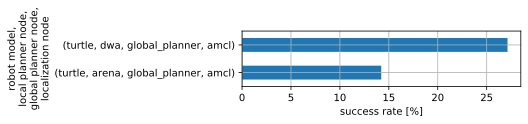

## collision_rate

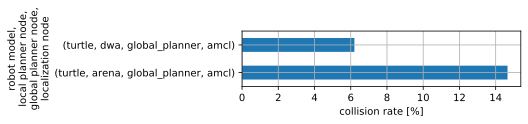

## average_velocity, only successful runs

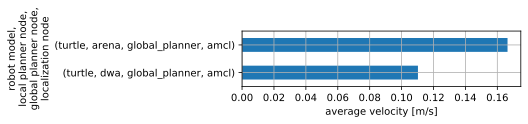

## norm_trajectory_length, only successful runs

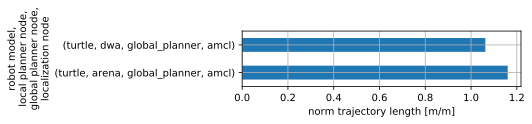

## norm_execution_time, only successful runs

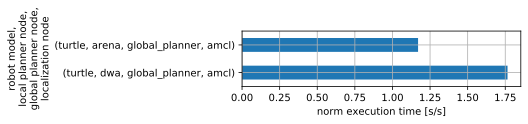

In [13]:
def bar_plot(metric_name, selected_df, y_columns=['robot_model', 'local_planner_node', 'global_planner_node', 'localization_node'], percentage=False, unit_symbol=None, higher_better=True):
    bar_df = selected_df.groupby(y_columns)[metric_name].agg(['mean', 'count']).sort_values(by=('mean'), ascending=higher_better)
    ax = (bar_df.sort_values(by=('mean'), ascending=higher_better)* (100 if percentage else 1) ).plot.barh(y=[('mean')], stacked=True, figsize=[10, 5], grid=True, legend=False)
    ax.set_xlabel(metric_name.replace('_', ' ').replace(',', ', ') + (f" [{unit_symbol}]" if unit_symbol else ""))
    ax.set_ylabel(ax.get_ylabel().replace('_', ' ').replace(',', ',\n'))
    plt.gcf().set_size_inches([5, 1])
    plt.show()
printmd("## success rate")
bar_plot(metric_name='success_rate', selected_df=df[(df.max_steering_angle_deg == 90.0)], percentage=True, higher_better=True, unit_symbol='%')
printmd("## collision_rate")
bar_plot(metric_name='collision_rate', selected_df=df[(df.max_steering_angle_deg == 90.0)], percentage=True, higher_better=False, unit_symbol='%')
printmd("## average_velocity, only successful runs")
bar_plot(metric_name='average_velocity', selected_df=df[(df.success_rate == 1) & (df.max_steering_angle_deg == 90.0)], higher_better=True, unit_symbol='m/s')
printmd("## norm_trajectory_length, only successful runs")
bar_plot(metric_name='norm_trajectory_length', selected_df=df[(df.success_rate == 1) & (df.max_steering_angle_deg == 90.0)], higher_better=False, unit_symbol='m/m')
printmd("## norm_execution_time, only successful runs")
bar_plot(metric_name='norm_execution_time', selected_df=df[(df.success_rate == 1) & (df.max_steering_angle_deg == 90.0)], higher_better=False, unit_symbol='s/s')

In [14]:
max_scatter_points = 200
def plot_in_out_metrics_bin_width_save(output_metric, input_metrics, bin_widths, min_bin_count, selected_df, out_dir, min_y=0.0, plot_all=True, scatter=True):
    max_y = -np.inf
#     scatter = False

    for i, (input_metric, bin_width) in enumerate(zip(input_metrics, bin_widths)):
        fig = plt.figure()

        for localization_node in df.localization_node.unique():
            for local_planner_node in df.local_planner_node.unique():
                
                df_lr = selected_df[
                    (selected_df.localization_node == localization_node) & 
                    (selected_df.local_planner_node == local_planner_node) & 
                    selected_df[input_metric.name].notna() & 
                    selected_df[output_metric.name].notna()
                ].copy()
                if len(df_lr[input_metric.name]):
                    if scatter:
                        n = max(1, int(len(df_lr[input_metric.name])/max_scatter_points))
                        plt.scatter(df_lr[input_metric.name][::n], df_lr[output_metric.name][::n], marker='.', s=0.25, color=local_planner_color[local_planner_node])
                    
                    if bin_width is not None:
                        if isinstance(bin_width, str):
                            _, bins = np.histogram(df_lr[input_metric.name], bins=bin_width)
                        else:
                            bins = np.arange(0., input_metric.max() + bin_width, bin_width)

                        df_lr['x_range'] = pd.cut(df_lr[input_metric.name], bins, labels=bins[:-1]).astype('float')
                        df_lr_g = df_lr.groupby('x_range').agg(['mean', 'count'])
                        df_lr_g = df_lr_g[ df_lr_g[(output_metric.name, 'count')] > min_bin_count ]
                        plt.plot(df_lr_g.index, df_lr_g[(output_metric.name, 'mean')], f'{local_planner_symbol[local_planner_node]}-', fillstyle='none', mfc=None, label=f'{local_planner_node}', linewidth=1, color=local_planner_color[local_planner_node])
                    else:
                        df_lr_g = df_lr.groupby(input_metric.name).agg(['mean', 'count'])
                        df_lr_g = df_lr_g[ df_lr_g[(output_metric.name, 'count')] > min_bin_count ]
                        plt.plot(df_lr_g.index, df_lr_g[(output_metric.name, 'mean')], f'{local_planner_symbol[local_planner_node]}-', fillstyle='none', mfc=None, label=f'{local_planner_node}', linewidth=1, color=local_planner_color[local_planner_node])
                    max_y = max(max_y, df_lr_g[(output_metric.name, 'mean')].max())

        if i == 0:
            plt.legend()
        plt.grid()
        plt.xlabel(input_metric.name.replace('_', ' '))
        plt.ylabel(output_metric.name.replace('_', ' '))
        plt.ylim([min_y, max_y*1.1])
        fig.set_size_inches([4, 4])
        if not path.exists(out_dir):
            os.makedirs(out_dir)
        fig.savefig(out_dir + f"/{output_metric.name}---{input_metric.name}.pdf".replace('_', '-'), bbox_inches='tight')
        plt.show()


## Localization perf from system features

### absolute translation error

No handles with labels found to put in legend.


ValueError: Axis limits cannot be NaN or Inf

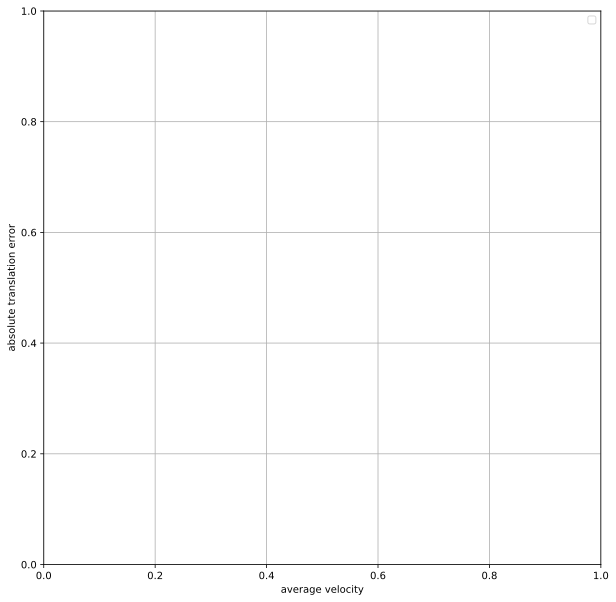

In [15]:
printmd("## Localization perf from system features")

d = df[(df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl')].copy()
min_bin_count = 10
input_metrics, bin_widths = zip(*[
    [d.average_velocity, 0.02], 
    [d.average_translation_velocity, 0.02], 
    #[d.average_velocity_atan, 0.1],
    [d.beta_1, None],
])
output_metrics = [
    d.absolute_translation_error,
    d.absolute_rotation_error,
    d.normalized_relative_translation_error,
    d.normalized_relative_rotation_error,
]
for output_metric in output_metrics:
    printmd(f"### {output_metric.name.replace('_', ' ')}")
    plot_in_out_metrics_bin_width_save(
        output_metric=output_metric, 
        input_metrics=input_metrics, 
        bin_widths=bin_widths,
        min_bin_count=min_bin_count,
        selected_df=d,
        out_dir="thesis_plots/localization",
    )


printmd("## Localization perf from own parameters")

d = df[(df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl') & (df.amcl_alpha_factor != 0)].copy()
min_bin_count = 10
input_metrics, bin_widths = zip(*[
    [d.amcl_alpha_factor, None],
])
output_metrics = [
    d.absolute_translation_error,
    d.absolute_rotation_error,
    d.normalized_relative_translation_error,
    d.normalized_relative_rotation_error,
]
for output_metric in output_metrics:
    printmd(f"### {output_metric.name.replace('_', ' ')}")
    plot_in_out_metrics_bin_width_save(
        output_metric=output_metric, 
        input_metrics=input_metrics, 
        bin_widths=bin_widths,
        min_bin_count=min_bin_count,
        selected_df=d,
        out_dir="thesis_plots/localization",
    )

In [ ]:
# printmd("## avg vel and avg vel atan are similar")
# d = df[(df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl')].copy()
# input_metrics = [
#     d.average_translation_velocity,
#     d.average_rotation_velocity,
#     d.average_velocity_atan,
# ]
# bin_widths = [0.02, 0.05, 0.1]
# min_bin_count = 10
# plot_in_out_metrics_bin_width_save(
#     output_metric=d.average_translation_velocity, 
#     input_metrics=input_metrics, 
#     bin_widths=bin_widths,
#     min_bin_count=min_bin_count,
#     selected_df=d,
#     scatter=True,
#     out_dir="thesis_plots/motion_char_self_correlation",
# )
# plot_in_out_metrics_bin_width_save(
#     output_metric=d.average_rotation_velocity, 
#     input_metrics=input_metrics, 
#     bin_widths=bin_widths,
#     min_bin_count=min_bin_count,
#     selected_df=d,
#     scatter=True,
#     out_dir="thesis_plots/motion_char_self_correlation",
# )
# plot_in_out_metrics_bin_width_save(
#     output_metric=d.average_velocity_atan, 
#     input_metrics=input_metrics, 
#     bin_widths=bin_widths,
#     min_bin_count=min_bin_count,
#     selected_df=d,
#     scatter=True,
#     out_dir="thesis_plots/motion_char_self_correlation",
# )

In [ ]:

# print(df.goal_index)

bin_widths = [None, None, None]
d = df[(df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl')].copy()
input_metrics = [
    d.environment_name,
    d.run_duplicate_index,
    d.goal_index,
]

plot_in_out_metrics_bin_width_save(
    output_metric=d.minimum_clearance, 
    input_metrics=input_metrics, 
    bin_widths=bin_widths,
    min_bin_count=10,
    selected_df=d,
    plot_all=False,
    scatter=False,
    out_dir="thesis_plots/local_planner",
)
plot_in_out_metrics_bin_width_save(
    output_metric=d.average_velocity, 
    input_metrics=input_metrics, 
    bin_widths=bin_widths,
    min_bin_count=10,
    selected_df=d,
    plot_all=False,
    scatter=False,
    out_dir="thesis_plots/local_planner",
)

In [ ]:

# printmd("### norm trajectory length ← absolute translation error doesn't work because when absolute translation error is very small, the trajectories are very short and a small change in trajectory length causes a big change in norm trajectory length")

# for e in df.environment_name.unique():
#     printmd(f"## {e}")
#     bin_widths = [0.01]
#     min_bin_count = 10
#     d = df[(df.success_rate == 1) & (df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl') & (df.environment_name == e)].copy()
#     input_metrics = [
#         d.absolute_translation_error, 
#     ]
#     plot_in_out_metrics_bin_width_save(
#         output_metric=d.min_trajectory_length, 
#         input_metrics=input_metrics, 
#         bin_widths=bin_widths,
#         min_bin_count=min_bin_count,
#         selected_df=d,
#         plot_all=False,
#         scatter=False,
#         out_dir=f"thesis_plots/local_planner/{e}",
#     )
    
#     plot_in_out_metrics_bin_width_save(
#         output_metric=d.trajectory_length, 
#         input_metrics=input_metrics, 
#         bin_widths=bin_widths,
#         min_bin_count=min_bin_count,
#         selected_df=d,
#         plot_all=False,
#         scatter=False,
#         out_dir=f"thesis_plots/local_planner/{e}",
#     )
#     plot_in_out_metrics_bin_width_save(
#         output_metric=d.norm_trajectory_length, 
#         input_metrics=input_metrics, 
#         bin_widths=bin_widths,
#         min_bin_count=min_bin_count,
#         selected_df=d,
#         plot_all=False,
#         min_y=1.0,
#         scatter=False,
#         out_dir=f"thesis_plots/local_planner/{e}",
#     )


In [ ]:

# printmd("### norm trajectory length, trajectory length ← other localization error metrics")

# for e in df.environment_name.unique():
#     printmd(f"## {e}")
#     bin_widths = [0.03]
#     min_bin_count = 10
#     d = df[(df.success_rate == 1) & (df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl') & (df.environment_name == e)].copy()
#     input_metrics = [
#         d.normalized_relative_rotation_error, 
#     ]
#     plot_in_out_metrics_bin_width_save(
#         output_metric=d.min_trajectory_length, 
#         input_metrics=input_metrics, 
#         bin_widths=bin_widths,
#         min_bin_count=min_bin_count,
#         selected_df=d,
#         plot_all=False,
#         scatter=False,
#         out_dir=f"thesis_plots/local_planner/{e}",
#     )
#     plot_in_out_metrics_bin_width_save(
#         output_metric=d.trajectory_length, 
#         input_metrics=input_metrics, 
#         bin_widths=bin_widths,
#         min_bin_count=min_bin_count,
#         selected_df=d,
#         plot_all=False,
#         scatter=False,
#         out_dir=f"thesis_plots/local_planner/{e}",
#     )
#     plot_in_out_metrics_bin_width_save(
#         output_metric=d.norm_trajectory_length, 
#         input_metrics=input_metrics, 
#         bin_widths=bin_widths,
#         min_bin_count=min_bin_count,
#         selected_df=d,
#         plot_all=False,
#         min_y=1.0,
#         scatter=False,
#         out_dir=f"thesis_plots/local_planner/{e}",
#     )


In [ ]:


for e in df.environment_name.unique():
    printmd(f"## {e}")
    min_bin_count = 10
    d = df[(df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl') & (df.environment_name == e)].copy()
    bin_widths = [1, .1, .01]
    input_metrics = [
        d.maximum_clearance, 
        d.average_clearance, 
        d.minimum_clearance, 
    ]
    plot_in_out_metrics_bin_width_save(
        output_metric=d.average_velocity, 
        input_metrics=input_metrics, 
        bin_widths=bin_widths,
        min_bin_count=min_bin_count,
        selected_df=d,
        min_y=0.0,
        plot_all=False,
        scatter=True,
        out_dir=f"thesis_plots/local_planner/{e}",
    )


In [ ]:

printmd("## Local Planning perf (also system features)")

min_bin_count = 10
d = df[(df.success_rate == 1) & (df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl')].copy()
input_metrics, bin_widths = zip(*[
    [d.beta_1, None], 
    [d.amcl_alpha_factor, None],
    [d.minimum_clearance, .1],
    [d.average_clearance, 1],
])
plot_in_out_metrics_bin_width_save(
    output_metric=d.average_velocity, 
    input_metrics=input_metrics, 
    bin_widths=bin_widths,
    min_bin_count=min_bin_count,
    selected_df=d,
    plot_all=False,
    scatter=True,
    out_dir="thesis_plots/local_planner",
)
plot_in_out_metrics_bin_width_save(
    output_metric=d.average_velocity_atan, 
    input_metrics=input_metrics, 
    bin_widths=bin_widths,
    min_bin_count=min_bin_count,
    selected_df=d,
    plot_all=False,
    scatter=True,
    out_dir="thesis_plots/local_planner",
)

In [ ]:
## plots_local_planner

printmd("## Local Planning perf (not system features)")

min_bin_count = 10

d = df[(df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl')].copy()
input_metrics, bin_widths = zip(*[
    [d.beta_1, None], 
    [d.amcl_alpha_factor, None],
    [d.average_clearance, 1],
])
plot_in_out_metrics_bin_width_save(
    output_metric=d.success_rate, 
    input_metrics=input_metrics, 
    bin_widths=bin_widths,
    min_bin_count=min_bin_count,
    selected_df=d,
    out_dir="thesis_plots/local_planner",
    plot_all=False,
)
plot_in_out_metrics_bin_width_save(
    output_metric=d.collision_rate, 
    input_metrics=input_metrics, 
    bin_widths=bin_widths,
    min_bin_count=min_bin_count,
    selected_df=d,
    out_dir="thesis_plots/local_planner",
    plot_all=False,
)

d = df[(df.success_rate == 1) & (df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl')].copy()
input_metrics, bin_widths = zip(*[
    [d.beta_1, None], 
    [d.amcl_alpha_factor, None],
    [d.minimum_clearance, .1],
    [d.average_clearance, 1],
])
plot_in_out_metrics_bin_width_save(
    output_metric=d.norm_trajectory_length, 
    input_metrics=input_metrics, 
    bin_widths=bin_widths,
    min_bin_count=min_bin_count,
    selected_df=d,
    min_y=1.0,
    plot_all=False,
    out_dir="thesis_plots/local_planner",
)
plot_in_out_metrics_bin_width_save(
    output_metric=d.norm_execution_time, 
    input_metrics=input_metrics, 
    bin_widths=bin_widths,
    min_bin_count=min_bin_count,
    selected_df=d,
    min_y=1.0,
    plot_all=False,
    out_dir="thesis_plots/local_planner",
)

In [ ]:
# ## plots_local_planner

# min_bin_count = 10

# d = df[(df.success_rate == 1) & (df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl')].copy()
# input_metrics, bin_widths = zip(*[
# #     [d.beta_1, None], 
# #     [d.amcl_alpha_factor, None],
# #     [d.minimum_clearance, .1],
# #     [d.average_clearance, 1],
#     [d.absolute_translation_error, 0.05],
#     [d.absolute_rotation_error, 0.01],
#     [d.normalized_relative_translation_error, 0.05],
#     [d.normalized_relative_rotation_error, 0.05],
# ])

# printmd("## norm_trajectory_length")
# plot_in_out_metrics_bin_width_save(
#     output_metric=d.norm_trajectory_length, 
#     input_metrics=input_metrics, 
#     bin_widths=bin_widths,
#     min_bin_count=min_bin_count,
#     selected_df=d,
#     min_y=1.0,
#     plot_all=False,
#     scatter=True,
#     out_dir="thesis_plots/local_planner",
# )
# printmd("## norm_trajectory_length_std")
# plot_in_out_metrics_bin_width_save(
#     output_metric=d.norm_trajectory_length_std, 
#     input_metrics=input_metrics, 
#     bin_widths=bin_widths,
#     min_bin_count=min_bin_count,
#     selected_df=d,
#     min_y=1.0,
#     plot_all=False,
#     scatter=True,
#     out_dir="thesis_plots/local_planner",
# )
# printmd("## norm_trajectory_length_mean")
# plot_in_out_metrics_bin_width_save(
#     output_metric=d.norm_trajectory_length_mean, 
#     input_metrics=input_metrics, 
#     bin_widths=bin_widths,
#     min_bin_count=min_bin_count,
#     selected_df=d,
# #     min_y=1.0,
#     plot_all=False,
#     scatter=True,
#     out_dir="thesis_plots/local_planner",
# )
# printmd("## norm_trajectory_length_median")
# plot_in_out_metrics_bin_width_save(
#     output_metric=d.norm_trajectory_length_median, 
#     input_metrics=input_metrics, 
#     bin_widths=bin_widths,
#     min_bin_count=min_bin_count,
#     selected_df=d,
# #     min_y=1.0,
#     plot_all=False,
#     scatter=True,
#     out_dir="thesis_plots/local_planner",
# )

In [ ]:
df_s = df[(df.success_rate == 1) & (df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl')].copy()

bins = np.arange(df_s.trajectory_length.min(), df_s.trajectory_length.max(), 5)
df_s['trajectory_length_d'] = pd.cut(df_s.trajectory_length, bins, labels=bins[:-1]).astype('float')
df_lr_g = df_s.groupby('trajectory_length_d').agg(['mean', 'count'])

plt.plot(df_lr_g.index, df_lr_g[('absolute_translation_error', 'mean')], label='all', color='black', linewidth=4)

for environment_name in df_s.environment_name.unique():
    df_lr_g = df_s[df_s.environment_name == environment_name].groupby('trajectory_length_d').agg(['mean', 'count'])
    plt.plot(df_lr_g.index, df_lr_g[('absolute_translation_error', 'mean')], label=environment_name)

plt.xlabel('trajectory_length_d')
plt.ylabel('absolute_translation_error')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# 